In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import scipy
from scipy import optimize
import os
import sys 
import pickle
from functools import partial
from scipy.ndimage import gaussian_filter
import pandas as pd
from pathlib import Path
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from TrackScrap import TrackScrap as tr
from TrackScrap import general as gen

# include some extra code 
d_extraCode = Path.cwd().parent / 'extraCode'
sys.path.append(str(d_extraCode))
import zoneModelFit as zmf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Definitions 

In [2]:
# paths 
d_save = Path.cwd().parent / 'outTest'
d_data = d_save.parent / 'data'
f_data = d_data / 'datExample.csv'
# video-properties:
fps = 30
pxPerCm = 15.3
min_prob = 0.85
# conversion:
UnitsSpeed = fps/pxPerCm
UnitsAccel = fps**2/pxPerCm
# processing
smooWin = 1.1153 # computed in section "Chose smoothening window"
# fish properties
BL = 2.4 # body length in cm
BlInPx = BL * pxPerCm
# to have reproducible notebook
np.random.seed(3123)

# Data cleaning
* 1. estimate the mean speed
* 2. reload all data and remove jump- and zigzag-artifacts

## Mean speed estimation
* be restrictive (prob > 0.5) to estimate mean-spead to exclude zigzags

In [3]:
# 0. load all particles 
vid = tr.IDTracker_TS(f_data)
# 1. exclude nans, low IDtracker-probability, and too short blocks
vid.exclude_nans()
vid.exclude_low_prob(0.5)
# 2. create for every valid-Block a Data-object (contains speed, acceleration, NND, ...)
vid.make_data_plus(smooWin, False) # no smoothening done (smooth=False)
# 3. merge from all blocks the velocities -> mean
speed = vid.merge_Dat('s')
meanSpeed = np.mean(speed)

/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:108: RuntimeWarning: invalid value encountered in less
  there = np.where(dat < mind)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TSPosition.py:305: RuntimeWarning: invalid value encountered in arccos
  d_phi = np.arccos(np.sum(u[:-1] * u[1:], axis=1))


## Remove tracking artifacts 

(8907, 8, 2)


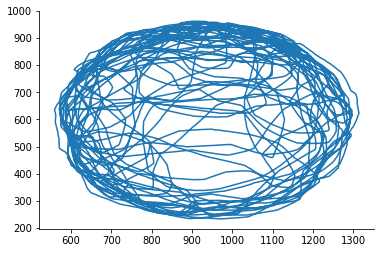

In [4]:
ID = 1
vid = tr.IDTracker_TS(f_data)
vid.exclude_nans()
print(vid.dat.shape)
plt.plot(vid.dat[:, ID, 0], vid.dat[:, ID, 1])

In [5]:
print('the valid blocks before the jumps and zigzags are exluded:')
print(vid.v_block)
# blocks = vid.exclude_jumps(maxSpeed, meanSpeed, returnBlocks=True)
jump_blocks = vid.exclude_jumps2(returnBlocks=True)
zigzag_blocks = vid.exclude_zigZag(meanSpeed*0.5, returnBlocks=True)

the valid blocks before the jumps are:
[[   0 8906]]


/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: divide by zero encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: invalid value encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:99: RuntimeWarning: invalid value encountered in greater
  case1 = (0.8 < case1) & (case1 < 1.2) & (acc[:-1] > 0)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:99: RuntimeWarning: invalid value encountered in less
  case1 = (0.8 < case1) & (case1 < 1.2) & (acc[:-1] > 0)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:101: RuntimeWarning: divide by zero encountered in true_divide
  case2 = (acc[:-1] / v[:-2]) > 2
/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:228: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(v0[:, 0] * v1[:, 0] + v0[:, 1] * v1[:, 1])
/home/klamser/Gitrepos/T

# Chose smoothening window
* counted manually the bursts in a specific trajectory
* "real" number of updates approximated to 206 for individual with ID=3 in the first valid block of the given test Video 
    * real video name "cut_LS1_190_1_2.csv" (for ensure later reproducion)
    * 1st valid block is [0, 2014]

In [6]:
# definitions:
ID = 3
countedUpdates = 206

In [7]:
# 0. load only trajectory of particles with ID=3
vid = tr.IDTracker_TS(f_data, ID-1)
# 1. clean data
vid.exclude_nans()
vid.exclude_jumps2()
vid.exclude_zigZag(meanSpeed*0.5)

/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: divide by zero encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:228: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(v0[:, 0] * v1[:, 0] + v0[:, 1] * v1[:, 1])
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:135: RuntimeWarning: invalid value encountered in greater
  case1 = (case1[:-1] > angle) & (case1[1:] > angle)


In [8]:
stds_smoo = np.linspace(0.5, 2, 40)
updates = []
for std in stds_smoo:
    vid.make_data_plus(std, True)
    da = vid.Dat[0]
    upt = gen.find_blocks_large(da.acc_s + da.d_phi * da.s, 0, 1, 1)
    upt = gen.find_blocks_large(da.acc_s, 0, 1, 1)
    upt = np.array([upt[0] for upt in upt])
    updates.append(len(upt))
updates = np.array(updates)

/home/klamser/Gitrepos/TrackScrap/TrackScrap/TSPosition.py:305: RuntimeWarning: invalid value encountered in arccos
  d_phi = np.arccos(np.sum(u[:-1] * u[1:], axis=1))


In [9]:
best_index = np.argmin(np.abs(updates - countedUpdates))
print('best std:', stds_smoo[best_index])
smooWin = stds_smoo[best_index]
print('best std:', smooWin)

best std: 1.1153846153846154
best std: 1.1153846153846154


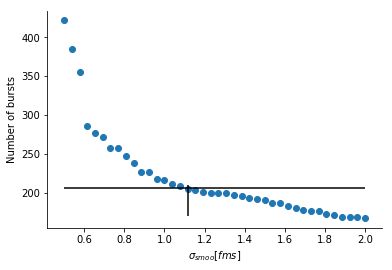

In [10]:
plt.scatter(stds_smoo, updates)
plt.hlines(206, stds_smoo.min(), stds_smoo.max())
plt.xlabel(r'$\sigma_{smoo} [fms]$')
plt.ylabel('Number of bursts')
plt.vlines(stds_smoo[best_index], 170, 210)

# Parameter fitting 

In [11]:
dicParaFits = dict()

In [12]:
def StandardTrackScrap(vid, friction=None):
    vid.exclude_nans()
    vid.exclude_low_prob(min_prob)
    vid.exclude_jumps2()
    vid.exclude_zigZag(meanSpeed*0.5)
    vid.exclude_too_short(3)
    vid.make_data_plus(smooWin, True)
    for Dat in vid.Dat:
        Dat.get_burstCoastCharacter(friction=friction)

In [13]:
# load and clean data 
vid = tr.IDTracker_TS(f_data)
StandardTrackScrap(vid)

/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:108: RuntimeWarning: invalid value encountered in less
  there = np.where(dat < mind)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: divide by zero encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: invalid value encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:99: RuntimeWarning: invalid value encountered in greater
  case1 = (0.8 < case1) & (case1 < 1.2) & (acc[:-1] > 0)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:99: RuntimeWarning: invalid value encountered in less
  case1 = (0.8 < case1) & (case1 < 1.2) & (acc[:-1] > 0)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:101: RuntimeWarning: divide by zero encountered in true_divide
  case2 = (acc[:-1] / v[:-2]) > 2
/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:22

## 3zone model fit

In [14]:
f_LineBurstDic = d_save / 'DicBurstConstellation2Force.pkl'
BurstConstDic = dict()

In [15]:
# needed for 3zone-model-fitting
tankCenter, tankRadius = vid.tank_CenterAndRadius()
for i in range(vid.v_N):
    zmf.BurstConstellation(vid.Dat[i], BurstConstDic,
                           tankCenter, tankRadius, BlInPx)

In [16]:
# Run optimization to find smallest error
# define bounds: [repulsion_range, alignment_range, attraction_range]
bounds = [(0, 300), (0, 600), (0, 600)]
partForceDifference = partial(zmf.forceDifference,
                              extra_data=[BurstConstDic['relPos2Burster'],
                                          BurstConstDic['relVel2Burster'],
                                          BurstConstDic['headingBursterEnd']])
BurstConstDic['optiOut'] = optimize.differential_evolution(partForceDifference, bounds)
# datDic['optiOut_DA'] = optimize.dual_annealing(partForceDifference, bounds)
with f_LineBurstDic.open('wb') as f_open:
    pickle.dump(BurstConstDic, f_open)

In [17]:
print(BurstConstDic['optiOut'])
# print(datDic['optiOut_DA'])

     fun: 1.3886319958952273
 message: 'Optimization terminated successfully.'
    nfev: 759
     nit: 14
 success: True
       x: array([ 67.21181182,   4.37091247, 166.97869385])


### Check the parameter space around the optima

In [18]:
BlInPxInt = np.round(BlInPx, 0)
print(BlInPx)

36.72


In [19]:
# check the parameter space around the optima and the sensitivity on the parameters
def ZoneBorders2WidthBorder(zbs, keep_rep=None):
    if keep_rep is None:
        keep_rep = True 
    if not keep_rep:
        zbs[0, zbs[1]<zbs[0]] = zbs[1, zbs[1]<zbs[0]]
    zbs[1] = np.diff(zbs[:2], axis=0)
    zbs[1, zbs[1]<0] = 0 
    zbs[2] -= np.sum(zbs[:2], axis=0)
    zbs[2, zbs[2]<0] = 0 
dicShort = BurstConstDic
theRange = np.arange(-2*BlInPxInt, 2*BlInPxInt+1, step=4)
x = dicShort['optiOut']['x']
zoneBorders = np.array([x[0], np.sum(x[:2]), np.sum(x)])
zoneBorderScans = zoneBorders[:, None] + theRange[None, :]
dicShort['zoneBorder'] = zoneBorderScans
partForceDiff = partial(zmf.forceDifference, extra_data=[dicShort['relPos2Burster'],
                                                         dicShort['relVel2Burster'],
                                                         dicShort['headingBursterEnd']])
# 2DScan: x=r_rep, y=r_att
zone_rep, zone_att = np.meshgrid(zoneBorderScans[0], zoneBorderScans[2], indexing='ij')
N_paraPoints = np.prod(zone_rep.shape)
zbs = np.vstack((zone_rep.flatten(),
                 N_paraPoints*[zoneBorders[1]],
                 zone_att.flatten()))
# zbs=ZoneBorders in width of zones
ZoneBorders2WidthBorder(zbs)
dicShort['ScanRepAtt'] = np.reshape([partForceDiff(paras) for paras in zbs.T], zone_rep.shape)
rangeOrient = np.ones(zone_rep.shape[0]) * zoneBorders[1]
mask = zoneBorderScans[0] > zoneBorders[1]
rangeOrient[mask] = zoneBorderScans[0, mask]
dicShort['ScanRepAtt_rangeOri'] = rangeOrient
# 2DScan: x=r_rep, y=r_or
zone_rep, zone_ori = np.meshgrid(zoneBorderScans[0], zoneBorderScans[1], indexing='ij')
mask = zone_rep < zone_ori
N_paraPoints = mask.sum()
zbs = np.vstack((zone_rep[mask].flatten(),
                 zone_ori[mask].flatten(),
                 N_paraPoints*[zoneBorders[2]]))
ZoneBorders2WidthBorder(zbs)
scanResflat = [partForceDiff(paras) for paras in zbs.T]
scanRes = np.empty(zone_rep.shape, dtype=float) * np.nan
scanRes[mask] = scanResflat
dicShort['ScanRepOri'] = scanRes
# 2DScan: x=r_or, y=r_att
zone_ori, zone_att = np.meshgrid(zoneBorderScans[0], zoneBorderScans[1], indexing='ij')
N_paraPoints = np.prod(zone_rep.shape)
zbs = np.vstack((N_paraPoints*[zoneBorders[0]],
                 zone_ori.flatten(),
                 zone_att.flatten()))
ZoneBorders2WidthBorder(zbs, keep_rep=False)
dicShort['ScanOriAtt'] = np.reshape([partForceDiff(paras) for paras in zbs.T], zone_ori.shape)
rangeRep = np.ones(zone_ori.shape[0])*x[0]
mask = zoneBorderScans[1] < zoneBorders[0]
rangeRep[mask] = zoneBorderScans[1, mask]
dicShort['ScanOriAtt_rangeRep'] = rangeRep

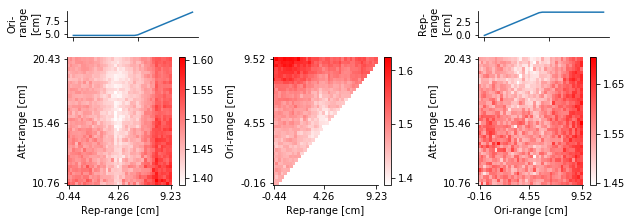

In [20]:
Lab2Int = {'Rep' : 0, 'Ori' : 1, 'Att' : 2}
kw = {'height_ratios':[0.2, 1]}
f, axs = plt.subplots(2, 3, gridspec_kw=kw,
                      figsize=0.8*plt.figaspect(1.3/3.6))
# plotting
dicShort = BurstConstDic
scanKeys = [k for k in dicShort.keys() if 'Scan' in k and '_' not in k]
labXs = []
for i, scanKey in enumerate(scanKeys):
    # scanKey = 'ScanOriAtt'
    labX, labY = scanKey[-6:-3], scanKey[-3:]
    labXs.append(labX)
    zmf.pcolor_bwr_zerowhite(f, axs[1, i], dicShort[scanKey].T, Nticks=3,
                             xvals=dicShort['zoneBorder'][Lab2Int[labX]]/pxPerCm,
                             yvals=dicShort['zoneBorder'][Lab2Int[labY]]/pxPerCm)
    axs[1, i].set_ylabel('{}-range [cm]'.format(labY))
    scanExtra = [k for k in dicShort.keys() if scanKey in k and 'range' in k]
    if len(scanExtra) == 1:
        scanExtra = scanExtra[0]
        axs[0, i].plot(dicShort[scanExtra]/pxPerCm)
        labY = scanExtra[-3:]
        axs[0, i].set_ylabel('{}-\n range\n[cm]'.format(labY))
    else:
        axs[0, i].axis('off')
_ = [ax.set_xticklabels([]) for ax in axs[::2].flatten()]
_ = [ax.set_xlabel('{}-range [cm]'.format(labXs[i])) for i, ax in enumerate(axs[-1])]
f.tight_layout()
f_save = d_save / 'SocialForceOptimaSurrounding.png'
f.savefig(str(f_save), dpi=200)

In [21]:
dicParaFits['r_rep'] = dicShort['optiOut']['x'][0] / pxPerCm
dicParaFits['r_ori'] = np.sum(dicShort['optiOut']['x'][:-1])  / pxPerCm
dicParaFits['r_att'] = np.sum(dicShort['optiOut']['x']) / pxPerCm

In [22]:
print(dicParaFits['r_rep'], dicParaFits['r_ori'], dicParaFits['r_att'])

4.392928877097868 4.678609430486583 15.592249551080561


### No-Orientation repetition

former section resulted social forces without orientation-zone
-> now do the following:
* 1. Do a parameter scan with $r_{ori}=r_{rep}$
* 2. Identify the common attraction range $r_{att}$ with arbitrary differences in $r_{rep}$ between the lines

In [23]:
x = dicShort['optiOut']['x']
zoneBorders = x.copy()
zoneBorders[1] = x[0] # = end of orientation =start of orientation -> no orientation
zoneBorders[2] = x.sum()
def scanRangeReturn(values, extraRange=2*BlInPxInt, step=4):
    mini = max(0, values.min() - extraRange)
    maxi = values.max() + extraRange + 1
    scanRange = np.arange(mini, maxi, step=step)
    return scanRange
zoneBorderScans = [scanRangeReturn(zoneBorders[0]),
                   scanRangeReturn(zoneBorders[1]),
                   scanRangeReturn(zoneBorders[2])]
# 2DScan: x=r_rep, y=r_att
zone_rep, zone_att = np.meshgrid(zoneBorderScans[0], zoneBorderScans[2], indexing='ij')
N_paraPoints = np.prod(zone_rep.shape)
zbs = np.vstack((zone_rep.flatten(),
                 zone_rep.flatten(), # zone_ori=zone_rep -> NO ORIENTATION
                 zone_att.flatten()))
# zbs=ZoneBorders in width of zones
dicShort = BurstConstDic
dicShort['noOri_zoneBorder'] = zoneBorderScans
partForceDiff = partial(zmf.forceDifference, extra_data=[dicShort['relPos2Burster'],
                                                         dicShort['relVel2Burster'],
                                                         dicShort['headingBursterEnd']])
dicShort['noOri_ScanRepAtt'] = np.reshape([partForceDiff(paras)
                                          for paras in zbs.T], zone_rep.shape)

In [24]:
N_rep, N_att = dicShort['noOri_ScanRepAtt'].shape
dat = scipy.ndimage.gaussian_filter(dicShort['noOri_ScanRepAtt'], 2)

rep-range 0.0  cm
att-range 18.34  cm


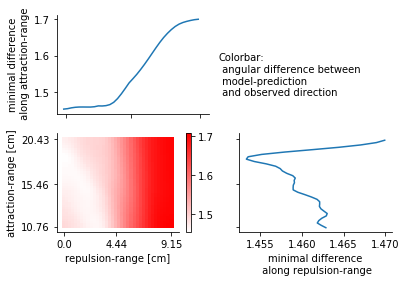

In [25]:
f, axs = plt.subplots(2, 2, sharex='col', sharey='row')
zmf.pcolor_bwr_zerowhite(f, axs[1, 0], dat.T, Nticks=3,
                         xvals=dicShort['noOri_zoneBorder'][0]/pxPerCm,
                         yvals=dicShort['noOri_zoneBorder'][2]/pxPerCm)
xes = [dat.min(axis=0), range(N_rep)]
yes = [range(N_att), dat.min(axis=1)]
for i, ax in enumerate([axs[1, 1], axs[0, 0]]):
    ax.plot(xes[i], yes[i])
axs[0, 1].axis('off')
# LABELS
axs[1, 0].set_ylabel('attraction-range [cm]')
axs[1, 0].set_xlabel('repulsion-range [cm]')
axs[0, 0].set_ylabel('minimal difference\n along attraction-range')
axs[1, -1].set_xlabel('minimal difference\n along repulsion-range')
f.text(0.5, 0.6, 'Colorbar:\n angular difference between\n model-prediction\n and observed direction', color='k')
# OPTIMUM:
opti_repRange = dicShort['noOri_zoneBorder'][0][np.argmin(dat.min(axis=1))]
opti_attRange = dicShort['noOri_zoneBorder'][2][np.argmin(dat.min(axis=0))]
print('rep-range', np.round(opti_repRange/pxPerCm, 2), ' cm')
print('att-range', np.round(opti_attRange/pxPerCm, 2), ' cm')

In [26]:
# note that more data makes the current optima (rep_range=0) vanish
# and the second maxima is better at rep_range=4cm

## Friction coefficient estimation

In [27]:
# initialize data-structure
dicIndis = dict()
dicIndisMean = dict()
attris = ['up_len', 'up_rate', 'up_acc', 'coast_acc', 'coast_s',
          'burst_acc_s', 'burst_acc_v', 'burst_acc_phi',
          'burst_s', 'burst_d_phi', 's']
# run analysis
    #     continue

# load and clean data 
for ID in range(8):
    vid = tr.IDTracker_TS(f_data, ID)
    StandardTrackScrap(vid)
    for att in attris:
        res = vid.merge_Dat(att)
        if type(res) == list:
            res = np.array(gen.listFlatten(res))
        res = res.flatten()
        gen.append2key(dicIndis, att, res)
        gen.append2key(dicIndisMean, att, [np.mean(res)])

/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: divide by zero encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:108: RuntimeWarning: invalid value encountered in less
  there = np.where(dat < mind)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:228: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(v0[:, 0] * v1[:, 0] + v0[:, 1] * v1[:, 1])
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:135: RuntimeWarning: invalid value encountered in greater
  case1 = (case1[:-1] > angle) & (case1[1:] > angle)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: invalid value encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:99: RuntimeWarning: invalid value encountered in greater
  case1 = (0.8 < case1) & (case1 < 1.2) & (acc[:-1] > 0)
/home/klamser/Gitrepos/TrackScrap/Trac

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


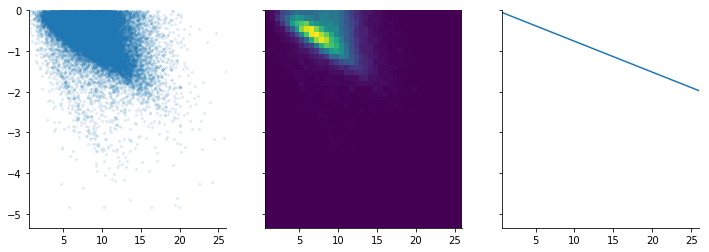

In [28]:
x = dicIndis['coast_s']
y = dicIndis['coast_acc']
f, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=plt.figaspect(1/3))
axs[0].scatter(x, y, alpha=0.1, s=4)
hist2dOut = axs[1].hist2d(x, y, bins=40)
slope, *_ = np.linalg.lstsq(x[:, None], y)
inter, slope = 0, slope[0]
xx = np.linspace(0, x.max(), 40)
axs[2].plot(xx, inter + slope * xx)

In [29]:
frictionFm = np.abs(slope)
print('friciton in units of pixel and frame: ', frictionFm)
print('in units cm and second: ', frictionFm*fps)
dicParaFits['friction'] = frictionFm*fps

friciton in units of pixel and frame:  0.0758641386206456
in units cm and second:  2.275924158619368


## Burst force estimation

In [30]:
# redo analysis with friction set -> returns corrected acceleration
att = 'up_accCorrected' 
for ID in range(8):
    vid = tr.IDTracker_TS(f_data, ID)
    StandardTrackScrap(vid, friction=frictionFm)
    res = np.array(gen.listFlatten(vid.merge_Dat(att)))
    gen.append2key(dicIndis, att, res)
    gen.append2key(dicIndisMean, att, [np.mean(res)])

/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: divide by zero encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:108: RuntimeWarning: invalid value encountered in less
  there = np.where(dat < mind)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:228: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(v0[:, 0] * v1[:, 0] + v0[:, 1] * v1[:, 1])
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:135: RuntimeWarning: invalid value encountered in greater
  case1 = (case1[:-1] > angle) & (case1[1:] > angle)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: invalid value encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:99: RuntimeWarning: invalid value encountered in greater
  case1 = (0.8 < case1) & (case1 < 1.2) & (acc[:-1] > 0)
/home/klamser/Gitrepos/TrackScrap/Trac

In [31]:
dicParaFits['burstForce'] = np.mean(dicIndisMean['up_acc']) * UnitsAccel
dicParaFits['burstForceCorrected'] = np.mean(dicIndisMean['up_accCorrected']) * UnitsAccel
print(dicParaFits['burstForce'], dicParaFits['burstForceCorrected'])

80.02968096416758 106.63002900014693


## Burst length and rate 
* attention the dicIndis['up_rate'] is actually a giant timeseries of updates or no updates (update=1)
    * the mean corresponds to the update rate with units [1/fms]

In [32]:
dicParaFits['burstRateRaw'] = np.mean(dicIndisMean['up_rate']) * fps 
dicParaFits['burstLengthRaw'] = np.mean(dicIndisMean['up_len']) / fps 
dicParaFits['burstRateRawStd'] = np.std(dicIndisMean['up_rate']) * fps 
dicParaFits['burstLengthRawStd'] = np.std(dicIndisMean['up_len']) / fps 
print(dicParaFits['burstRateRaw'], dicParaFits['burstLengthRaw'])
print(dicParaFits['burstRateRawStd'], dicParaFits['burstLengthRawStd'])

3.4988871940651576 0.1224515099487322
0.5616184699967867 0.010447782499613176


### Estimation via 1D-timeseries

In [33]:
time = 300
dt = 0.001 # same time-step as in the simulation
up_rate = 3.5 
up_dur = 0.121
def get_effectiveUp_rate_duration(up_rate, up_dur, dt, time, returnRaw=None):
    if returnRaw is None:
        returnRaw = False
    timeSteps = int(time/dt)
    up_len = int(up_dur / dt)
    acc = np.zeros(timeSteps, dtype=int)
    prob_burst = np.random.uniform(size=timeSteps)
    there_burst = np.where(prob_burst < dt * up_rate)[0]
    for i_burst in there_burst:
        acc[i_burst:i_burst+up_len] = 1
    blocks = gen.find_blocks_large(acc, 0, 1, 1)
    if returnRaw:
        return there_burst, acc, blocks[:, 0]
    effective_up_rate =  len(blocks)/time
    effective_up_dur = np.mean( (np.diff(blocks) + 1) * dt ) 
    return effective_up_rate, effective_up_dur
[effective_up_rate,
 effective_up_dur] = get_effectiveUp_rate_duration(up_rate, up_dur, dt, time)
print('effective up_rate', effective_up_rate)
print('effective up_dur', effective_up_dur )

effective up_rate 2.2666666666666666
effective up_dur 0.1512544117647059


In [34]:
fine = 100
upRates = np.linspace(3, 10, fine)
upDurs = np.arange(40 * dt, 0.121, step=dt)
results = np.empty((fine, len(upDurs), 2))
for i, rate in enumerate(upRates):
    for j, dur in enumerate(upDurs):
        results[i, j] = get_effectiveUp_rate_duration(rate, dur, dt, time)

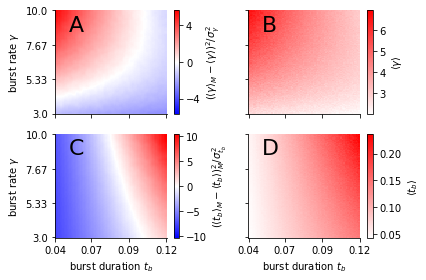

In [35]:
f, axs = plt.subplots(2, 2, figsize=1*plt.figaspect(2/3), sharex=True, sharey=True)
pcolorBWR = partial(zmf.pcolor_bwr_zerowhite, f, xvals=upDurs, yvals=upRates)
sigmas = [( ( np.diff(upRates)[0] / dicParaFits['burstRateRawStd']) /
            ( np.diff(upDurs)[0] / dicParaFits['burstLengthRawStd'])),
          1]
dat0 = results[:, :, 0]
dat0 = gaussian_filter(dat0, sigmas)
dat0 = (dat0 - dicParaFits['burstRateRaw']) / dicParaFits['burstRateRawStd']
pcolorBWR(axs[0, 0], dat0,
          cLabel=r'$(\langle\gamma\rangle_M - \langle\gamma\rangle)^2/\sigma_{\gamma}^2$')
dat1 = results[:, :, 1]
dat1 = gaussian_filter(dat1, sigmas)
dat1 = (dat1 - dicParaFits['burstLengthRaw']) / dicParaFits['burstLengthRawStd']
error = dat0**2 + dat1**2
pcolorBWR(axs[1, 0], dat1,
          cLabel=r'$(\langle t_b\rangle_M - \langle t_b\rangle)_M^2/\sigma_{t_b}^2$')
# plotting
pcolorBWR(axs[0, 1], results[:, :, 0], cLabel=r'$\langle\gamma\rangle$')
pcolorBWR(axs[1, 1], results[:, :, 1], cLabel=r'$\langle t_b\rangle$')
# Axs LABELS 
_ = [ax.set_ylabel(r'burst rate $\gamma$') for ax in axs[:, 0]]
_ = [ax.set_xlabel(r'burst duration $t_b$') for ax in axs[1, :]]
# ABC
texts = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
xtext = 10
ytext = 80
_ = [ax.text(xtext, ytext, texts[i], fontsize=22) for i, ax in enumerate(axs.flatten())]
f.tight_layout()
f_name = 'EstimationBurstRate_Duration.png'
# f.savefig(str(d_save / f_name), dpi=200)

In [36]:
there = np.where(error == error.min())
dicParaFits['burstRate'] = upRates[there[0][0]] 
dicParaFits['burstLength'] = upDurs[there[1][0]] 
print('Error: ', error.min(), there)
print('rate: ', dicParaFits['burstRate'], 'duration: ', dicParaFits['burstLength'])

Error:  6.624359695341499e-05 (array([45]), array([51]))
rate:  6.181818181818182 duration:  0.09100000000000005


## Group cohesion and individual Speed for the final model fit
* to fit the remaining parameters `prob_social` and `f_burst` the model is scaned along these 2 parameters with running `Scan2d.py` (before all the above defined parameters need to be set) 
* the results from `Scan2d.py` are compared to the speed and the nearest neighbor distance from the experiment
    * `prob_social` and `f_burst` which result in the smallest error are than the final parameters

### individual speed

In [37]:
dicParaFits['s'] = np.mean(dicIndisMean['s']) * UnitsSpeed
dicParaFits['sStd'] = np.std(dicIndisMean['s']) * UnitsSpeed

### Group cohesion
* note that for the dictionaries `dicIndisMean` and `dicIndis` each individual trajectory was cleaned
* now all trajectories are cleaned together, i.e. if one trajectory is corrupted at time t, all other trajectories are discarded for time t as well

In [38]:
# initialize structure
dicGrp = dict()
attris = ['nnd', 'IID', 'OP_pol', 'Area_ConvexHull']
# load and clean data 
vidGrp = tr.IDTracker_TS(f_data)
StandardTrackScrap(vidGrp)
for att in attris:
    res = vidGrp.merge_Dat(att)
    if type(res) == list:
        res = np.array(gen.listFlatten(res))
    res = res.flatten()
    gen.append2key(dicGrp, att, res)

/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:108: RuntimeWarning: invalid value encountered in less
  there = np.where(dat < mind)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: divide by zero encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:98: RuntimeWarning: invalid value encountered in true_divide
  case1 = -acc[:-1] / acc[1:]
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:99: RuntimeWarning: invalid value encountered in greater
  case1 = (0.8 < case1) & (case1 < 1.2) & (acc[:-1] > 0)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:99: RuntimeWarning: invalid value encountered in less
  case1 = (0.8 < case1) & (case1 < 1.2) & (acc[:-1] > 0)
/home/klamser/Gitrepos/TrackScrap/TrackScrap/TrackScrap.py:101: RuntimeWarning: divide by zero encountered in true_divide
  case2 = (acc[:-1] / v[:-2]) > 2
/home/klamser/Gitrepos/TrackScrap/TrackScrap/general.py:22

In [39]:
dicParaFits['nnd'] = np.mean(dicGrp['nnd']) / pxPerCm
# ATTENTION: In the paper I investigate different groups and 
#            there the standard deviation is over the mean values of all groups!!
#            Here is only 1 group and I compute the standard deviation differently.
#            Same holds for the mean.
dicParaFits['nndStd'] = np.std(dicGrp['nnd'])  / pxPerCm
dicParaFits['polarization'] = np.mean(dicGrp['OP_pol'])
dicParaFits['polarizationStd'] = np.std(dicGrp['OP_pol'])
print()